# EdgeR - Non-rarefied & abundance-filtered data 

In [20]:
library(edgeR)
library(phyloseq)
library(tidyverse)
library(metagMisc)
library(microViz)
library(conflicted)
library(pheatmap)
library(viridis)
library(gridExtra)
library(ggplot2)

Loading required package: viridisLite



In [21]:
conflict_prefer("count","dplyr")
conflict_prefer("filter","dplyr")

[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::count over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::filter over any other package.


In [22]:
psAll_count =readRDS("../psAll_count.rds")

In [23]:
psAll_count

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9963 taxa and 792 samples ]
sample_data() Sample Data:       [ 792 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9963 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9963 tips and 9945 internal nodes ]

In [24]:
#nonrare.psAll.filt=phyloseq_filter_prevalence(psAll, prev.trh = 0.05, abund.trh = 10,
 # threshold_condition = "OR", abund.type = "mean")
nonrare.psAll.filt=phyloseq_filter_prevalence(psAll_count, prev.trh = 0.05, abund.trh = 10,
  threshold_condition = "OR", abund.type = "mean")
nonrare.psAll.filt=prune_samples(sample_sums(nonrare.psAll.filt)>0,nonrare.psAll.filt)
nonrare.psAll.filt

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1454 taxa and 779 samples ]
sample_data() Sample Data:       [ 779 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1454 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1454 tips and 1453 internal nodes ]

In [25]:
tax_table_nonrare = as.data.frame(nonrare.psAll.filt@tax_table)%>%
rownames_to_column(var="Accession")

In [26]:
################################################################################
#' Convert phyloseq OTU count data into DGEList for edgeR package
#' 
#' Further details.
#' 
#' @param physeq (Required).  A \code{\link{phyloseq-class}} or
#'  an \code{\link{otu_table-class}} object. 
#'  The latter is only appropriate if \code{group} argument is also a 
#'  vector or factor with length equal to \code{nsamples(physeq)}.
#'  
#' @param group (Required). A character vector or factor giving the experimental
#'  group/condition for each sample/library. Alternatively, you may provide
#'  the name of a sample variable. This name should be among the output of
#'  \code{sample_variables(physeq)}, in which case
#'  \code{get_variable(physeq, group)} would return either a character vector or factor.
#'  This is passed on to \code{\link[edgeR]{DGEList}},
#'  and you may find further details or examples in its documentation.
#'  
#' @param method (Optional). The label of the edgeR-implemented normalization to use.
#'  See \code{\link[edgeR]{calcNormFactors}} for supported options and details. 
#'  The default option is \code{"RLE"}, which is a scaling factor method 
#'  proposed by Anders and Huber (2010).
#'  At time of writing, the \link[edgeR]{edgeR} package supported 
#'  the following options to the \code{method} argument:
#'  
#'  \code{c("TMM", "RLE", "upperquartile", "none")}.
#'
#' @param ... Additional arguments passed on to \code{\link[edgeR]{DGEList}}
#' 
#' @examples
#' 
phyloseq_to_edgeR = function(physeq, group, method="RLE", ...){
  require("edgeR")
  require("phyloseq")
  # Enforce orientation.
  if( !taxa_are_rows(physeq) ){ physeq <- t(physeq) }
  x = as(otu_table(physeq), "matrix")
  # Add one to protect against overflow, log(0) issues.
  x = x + 1
  # Check `group` argument
  if( identical(all.equal(length(group), 1), TRUE) & nsamples(physeq) > 1 ){
    # Assume that group was a sample variable name (must be categorical)
    group = get_variable(physeq, group)
  }
  # Define gene annotations (`genes`) as tax_table
  taxonomy = tax_table(physeq, errorIfNULL=FALSE)
  if( !is.null(taxonomy) ){
    taxonomy = data.frame(as(taxonomy, "matrix"))
  } 
  # Now turn into a DGEList
  y = DGEList(counts=x, group=group, genes=taxonomy, remove.zeros = TRUE, ...)
  # Calculate the normalization factors
  z = calcNormFactors(y, method=method)
  # Check for division by zero inside `calcNormFactors`
  if( !all(is.finite(z$samples$norm.factors)) ){
    stop("Something wrong with edgeR::calcNormFactors on this data,
         non-finite $norm.factors, consider changing `method` argument")
  }
  # Estimate dispersions
  return(estimateTagwiseDisp(estimateCommonDisp(z)))
}
################################################################################

## 1. Plants vs. animals

In [27]:
#nonrare.psAll.filt
subset.host.nonrare.filt=subset_samples(nonrare.psAll.filt,biome_1=="Host-associated")

varianceThreshold = 1e-5
keepOTUs = names(which(apply(otu_table(subset.host.nonrare.filt), 1, var) > varianceThreshold))
filter_taxa_host.deseq.nonrare.filt = prune_taxa(keepOTUs, subset.host.nonrare.filt)

dge.host.nonrare.filt = phyloseq_to_edgeR(filter_taxa_host.deseq.nonrare.filt, group="category")

# Perform binary test
et.nonrare.filt.host = exactTest(dge.host.nonrare.filt)

# Extract values from test results
tt.nonrare.filt.host = topTags(et.nonrare.filt.host, n=nrow(dge.host.nonrare.filt$table), adjust.method="BH", sort.by="PValue")
res.nonrare.filt.host = tt.nonrare.filt.host@.Data[[1]]
alpha = 0.001
sigtab.host.nonrare.filt = res.nonrare.filt.host[(res.nonrare.filt.host$FDR < alpha), ]

#sigtab = cbind(as.numeric(sigtab, "data.frame"), as(tax_table(filter_taxa_All2.deseq)[rownames(sigtab), ], "matrix"))
#dim(sigtab)

sigtab.host.nonrare.filt=filter(res.nonrare.filt.host,FDR<0.01)

In [28]:
nrow(sigtab.host.nonrare.filt)

[1] 353

In [29]:
head(tt.nonrare.filt.host)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SFH83235.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio sp900113655,2.869283,10.95110,1.488676e-127,2.164535e-124
EHS53753.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.621441,10.94221,8.408798e-105,6.113196e-102
KPF42046.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp001296045,1.675140,10.71848,1.246348e-50,6.040631e-48
PPQ20111.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Bradyrhizobium,s__Bradyrhizobium shewense,1.724657,10.71384,8.467270e-42,2.931656e-39
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,1.565110,10.72193,1.008135e-41,2.931656e-39
ACE93333.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Rhizobium,s__Rhizobium phaseoli,1.365366,10.67844,5.782088e-32,1.401193e-29


##### Export list of Differentially Abundant flagellins

In [30]:
DA.animalsvsplants = rownames_to_column(sigtab.host.nonrare.filt,var = "Accession")
#write_tsv(DA.animalsvsplants,"edgeR/DA.animalvsplant.nonrare.filt.tsv")
head(DA.animalsvsplants)

,Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,SFH83235.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio sp900113655,2.869283,10.95110,1.488676e-127,2.164535e-124
2,EHS53753.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.621441,10.94221,8.408798e-105,6.113196e-102
3,KPF42046.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp001296045,1.675140,10.71848,1.246348e-50,6.040631e-48
4,PPQ20111.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Bradyrhizobium,s__Bradyrhizobium shewense,1.724657,10.71384,8.467270e-42,2.931656e-39
5,WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,1.565110,10.72193,1.008135e-41,2.931656e-39
6,ACE93333.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Rhizobium,s__Rhizobium phaseoli,1.365366,10.67844,5.782088e-32,1.401193e-29


In [31]:
theme_set(theme_bw())
sigtabgen.host.filt.nonrare = subset(sigtab.host.nonrare.filt, !is.na(Genus))

# Phylum order
x = tapply(sigtab.host.nonrare.filt$logFC, sigtab.host.nonrare.filt$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtabgen.host.filt.nonrare$Phylum = factor(as.character(sigtabgen.host.filt.nonrare$Phylum), levels = names(x))

# Genus order
x = tapply(sigtabgen.host.filt.nonrare$logFC, sigtabgen.host.filt.nonrare$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen.host.filt.nonrare$Genus = factor(as.character(sigtabgen.host.filt.nonrare$Genus), levels = names(x))
           
# Family order
x = tapply(sigtabgen.host.filt.nonrare$logFC, sigtabgen.host.filt.nonrare$Family, function(x) max(x))
x = sort(x, TRUE)
sigtabgen.host.filt.nonrare$Family = factor(as.character(sigtabgen.host.filt.nonrare$Family), levels = names(x))

#### Plots

##### A. Phlyum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


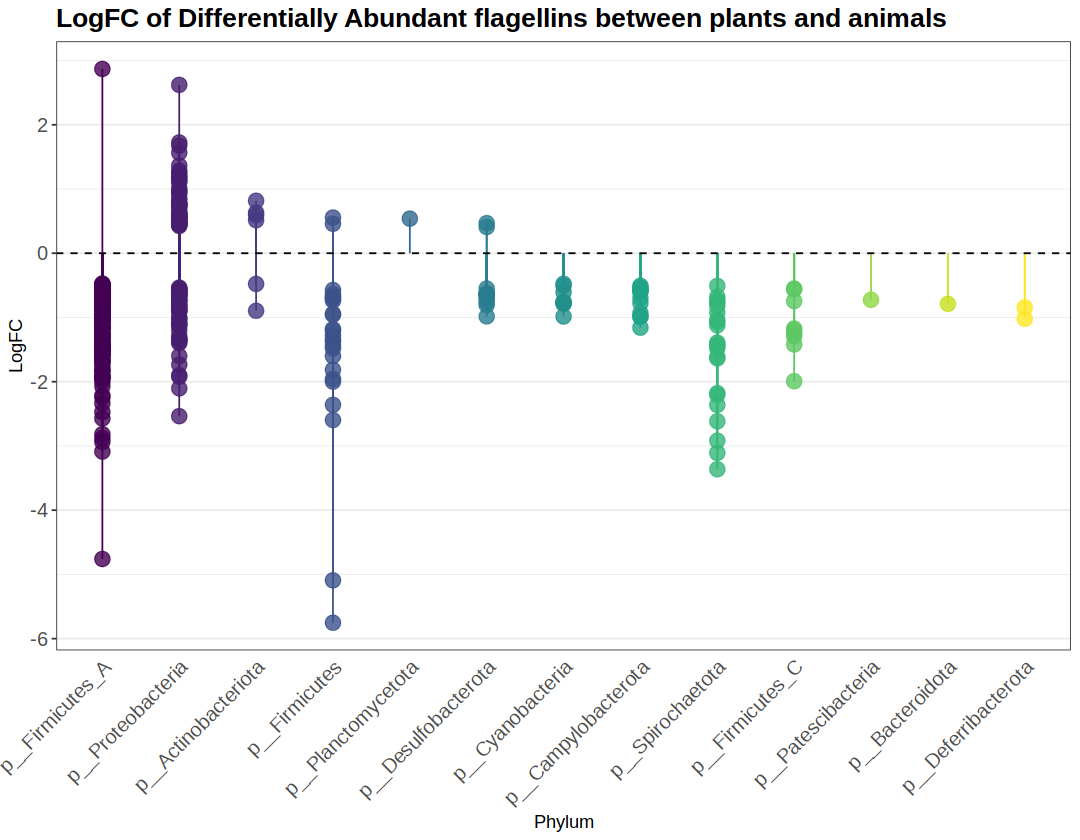

In [32]:
options(repr.plot.width=9,repr.plot.height=7)
ggplot(sigtabgen.host.filt.nonrare, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and animals")+
  labs(x = "Phylum", y = "LogFC")

##### B. Family-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


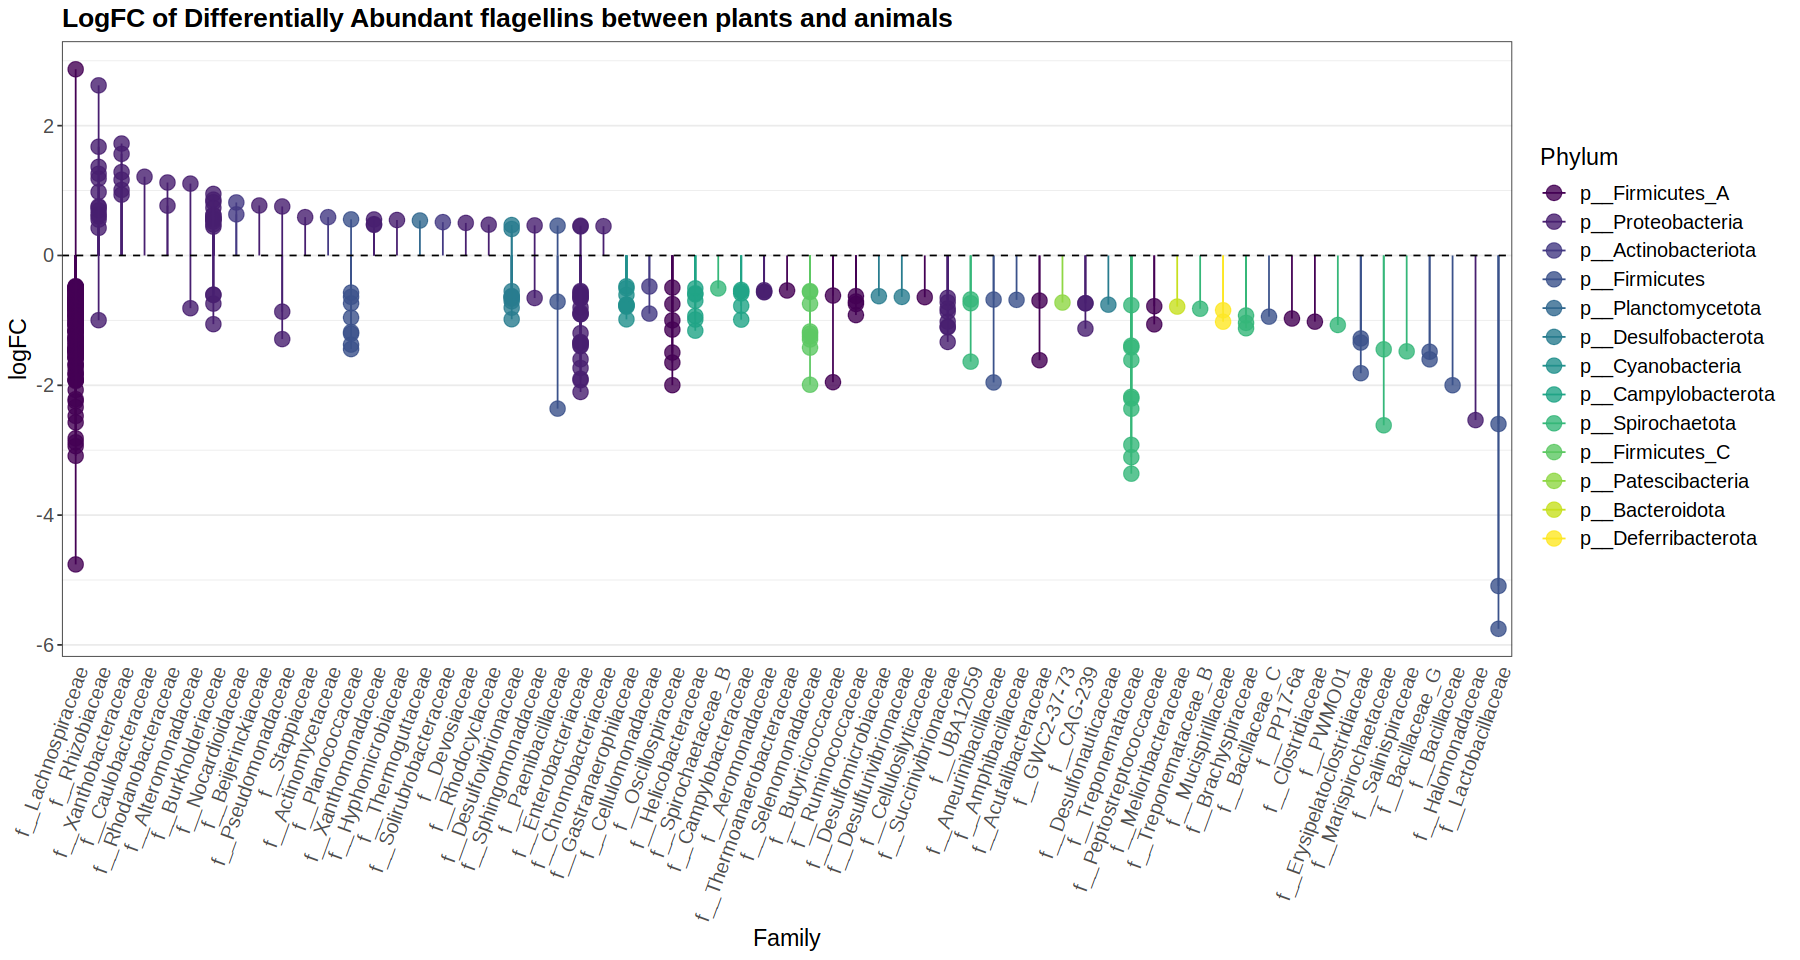

In [33]:
options(repr.plot.width=15,repr.plot.height=8)
ggplot(sigtabgen.host.filt.nonrare, aes(x = Family, y = logFC, color = Phylum)) + geom_point(size=4,alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Family,xend=Family),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and animals")

##### C. Genus-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


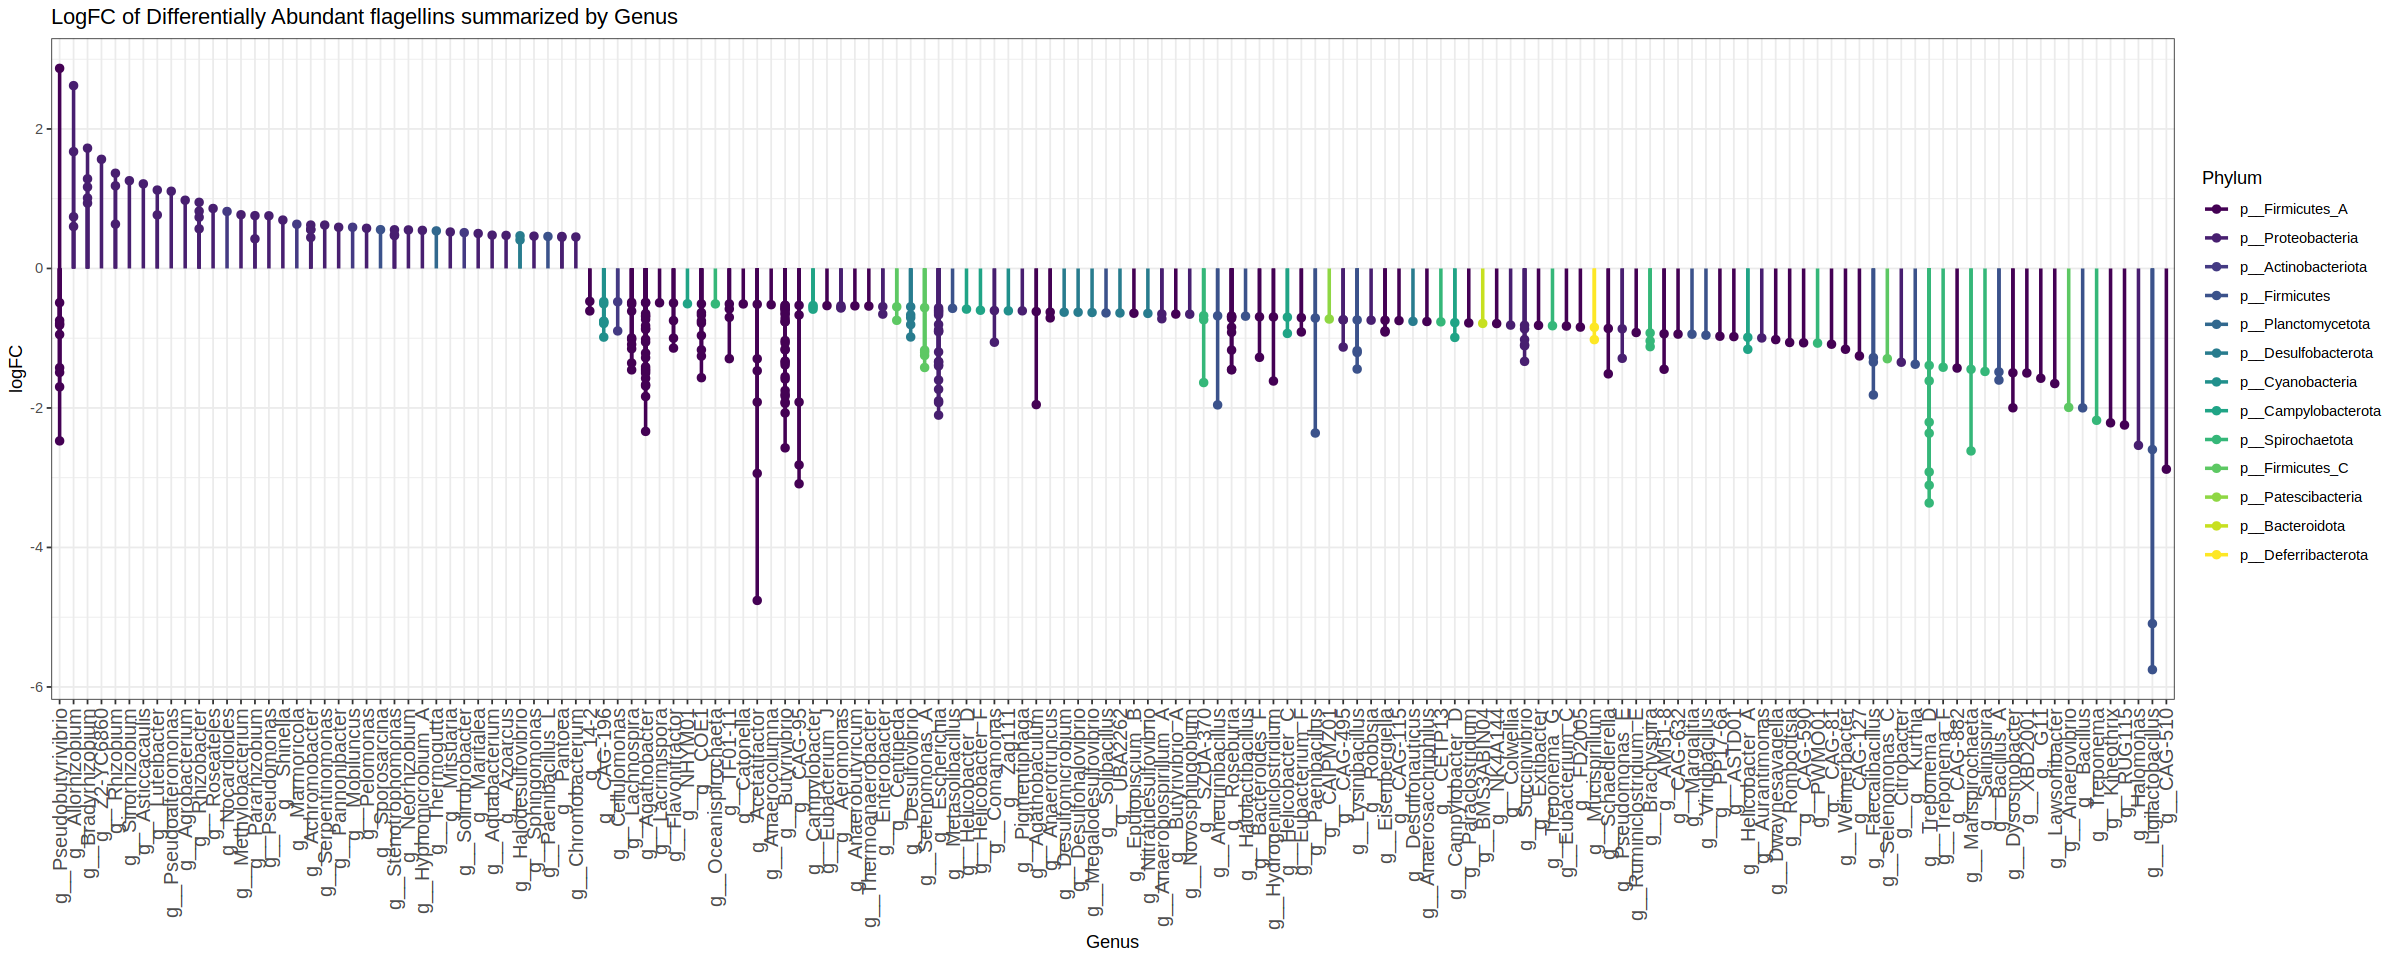

In [34]:
options(repr.plot.width=20,repr.plot.height=8)
ggplot(sigtabgen.host.filt.nonrare, aes(x = Genus, y = logFC, color = Phylum)) + geom_point(size=2) + 
  geom_segment(aes(y=0,yend=logFC,xend=Genus,xend=Genus),size=1)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size=12))+
  scale_color_viridis_d() +
  ggtitle("LogFC of Differentially Abundant flagellins summarized by Genus")

##### D. species-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


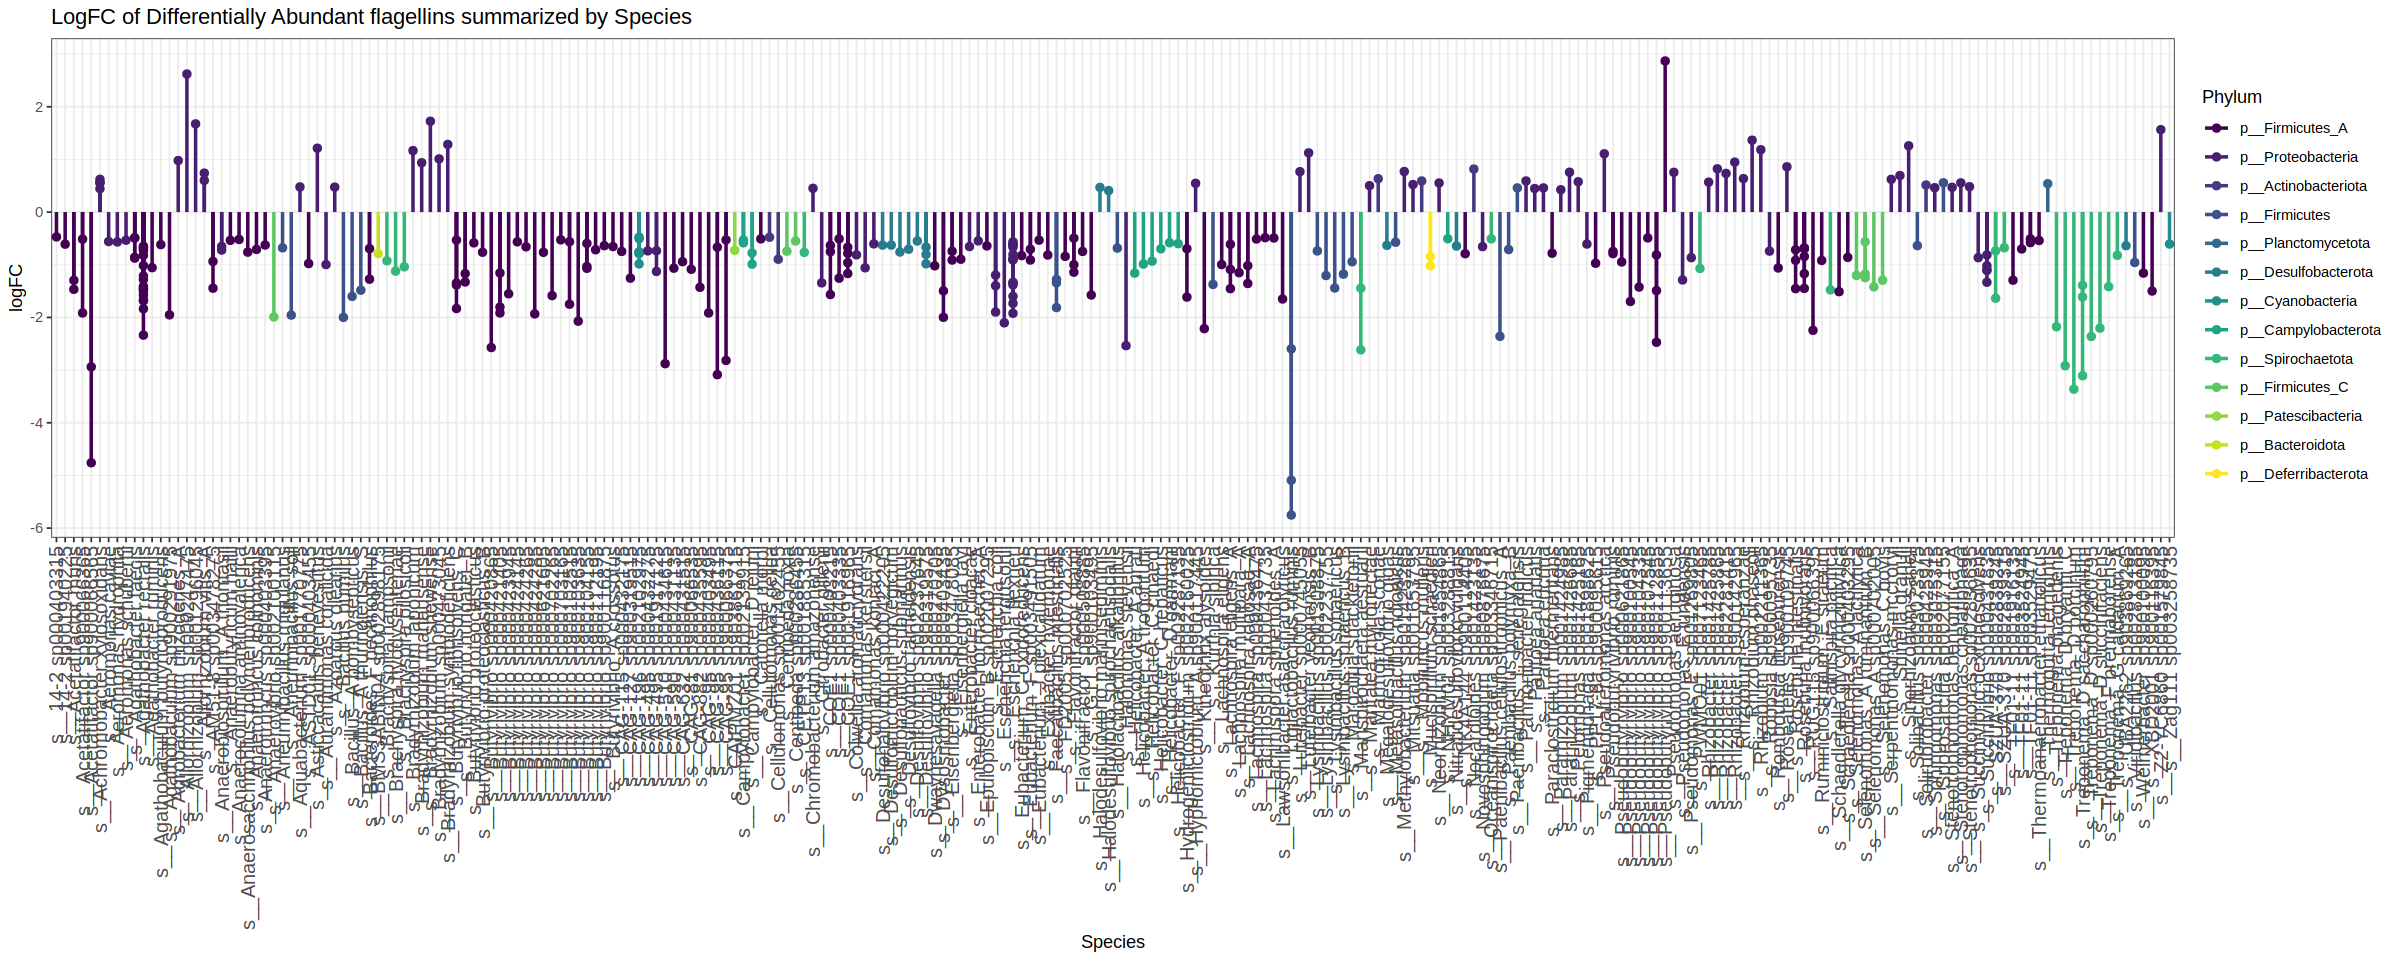

In [35]:
options(repr.plot.width=20,repr.plot.height=8)
ggplot(sigtabgen.host.filt.nonrare, aes(x = Species, y = logFC, color = Phylum)) + geom_point(size=2) + 
  geom_segment(aes(y=0,yend=logFC,xend=Species,xend=Species),size=1)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size=12))+
  scale_color_viridis_d()+
  ggtitle("LogFC of Differentially Abundant flagellins summarized by Species")

##### E. Plot hetamaps with DA flagellins

#### Heatmap DAs animal-plants

In [36]:
library(pheatmap)

In [37]:
DAs.host=rownames(sigtab.host.nonrare.filt)
DAs_fla_host = prune_taxa(DAs.host,subset.host.nonrare.filt)
DAs_fla_host

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 353 taxa and 646 samples ]
sample_data() Sample Data:       [ 646 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 353 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 353 tips and 352 internal nodes ]

#### Create function to map color to annotation

In [38]:
mapBiomeToColor<-function(annotations){
    colorsVector = ifelse(annotations["category"]=="Plants", 
        "darkcyan", ifelse(annotations["category"]=="Animal", 
        "coral", "red"))
    return(colorsVector)
}

#### Create data.frame with metadata annotations

In [39]:
annotation.host <- data.frame(sample=DAs_fla_host@sam_data$Sample,
                        biome2=DAs_fla_host@sam_data$biome_2,
                        category=DAs_fla_host@sam_data$category)
rownames(annotation.host)=annotation.host$sample

sampleColors.host = mapBiomeToColor(annotation.host)

#### Create colors vector based on annotations

In [40]:
cols.vector.host =(t(sampleColors.host))
cols.vector.host = sampleColors.host[2:nrow(sampleColors.host),]

In [41]:
annotation.col = select(annotation.host,-sample)

In [42]:
annotation.row=data.frame(DAs_fla_host@tax_table)

#### Create abundance matrix for heatmap

In [43]:
matrix.host=as.matrix(DAs_fla_host@otu_table[,2:ncol(DAs_fla_host@otu_table)])
rownames(matrix.host)=rownames(DAs_fla_host@otu_table)

Mt2_GH<-log((matrix.host*1000)+1)

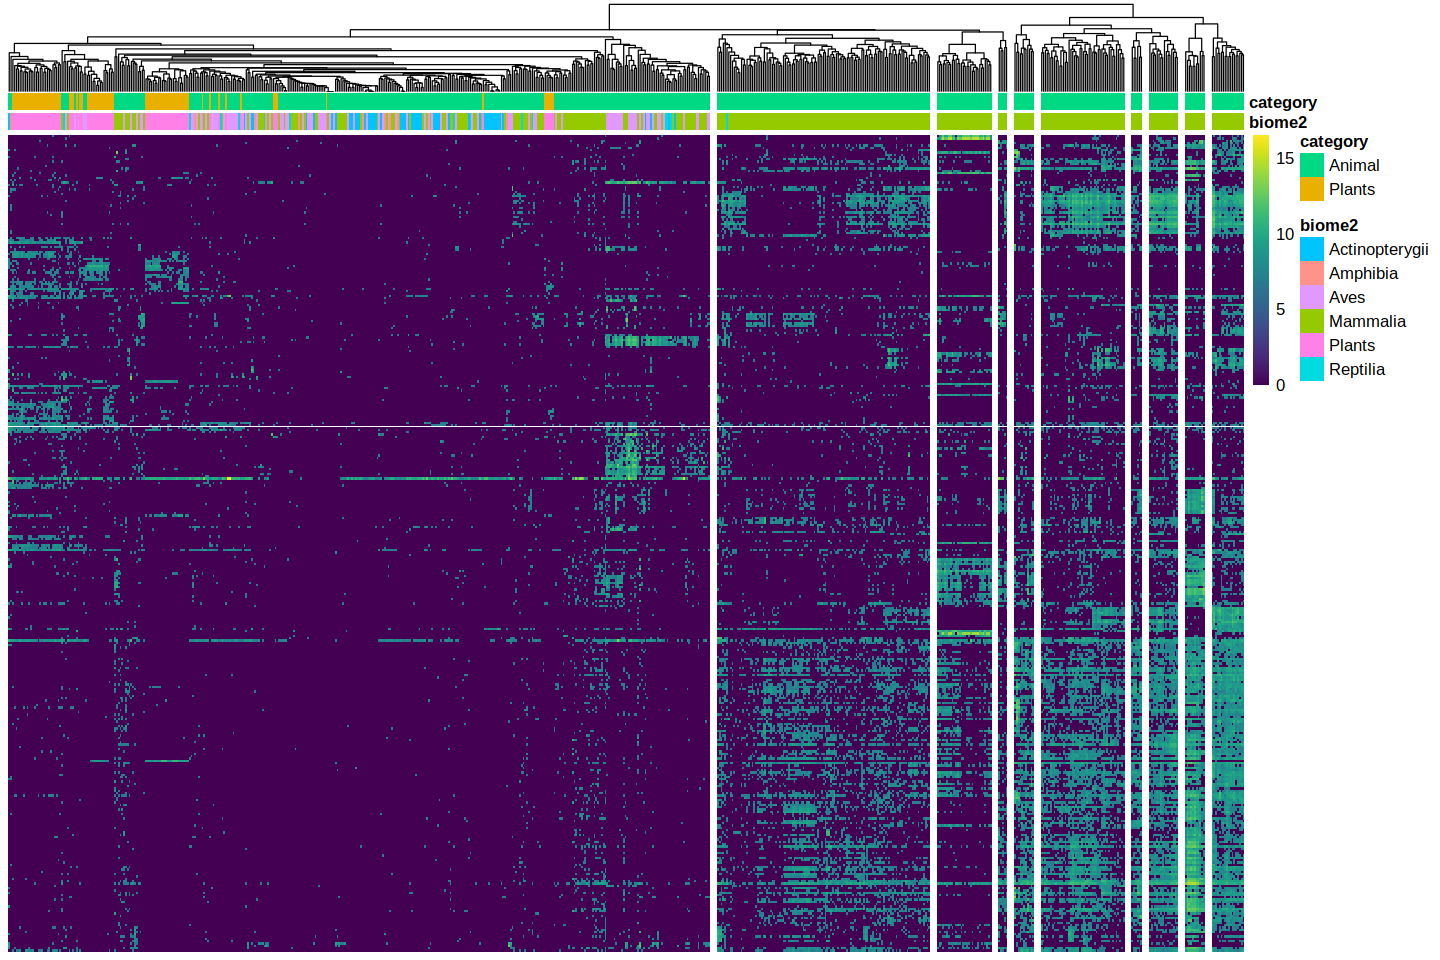

In [44]:
options(repr.plot.width=15,repr.plot.width=12)
pheatmap(Mt2_GH, cutree_cols = 10,
         cluster_cols=TRUE,
         cluster_rows=FALSE,
         show_rownames=F,
         show_colnames=F,
         labels_row=annotation.row$Phylum,
         annotation_col=annotation.col,
          color = viridis(n = 256, alpha = 1, 
                                   begin = 0, end = 1, option = "viridis")
)

## 2. Host vs. environmental

In [45]:
varianceThreshold = 1e-5
keepOTUs.biome1 = names(which(apply(otu_table(nonrare.psAll.filt), 1, var) > varianceThreshold))
filter_taxa_biome1.nonrare.filt = prune_taxa(keepOTUs.biome1, nonrare.psAll.filt)

dge.nonrare.filt = phyloseq_to_edgeR(filter_taxa_biome1.nonrare.filt, group="biome_1")
# Perform binary test
et.nonrare.filt = exactTest(dge.nonrare.filt)
# Extract values from test results
tt.nonrare.filt = topTags(et.nonrare.filt, n=nrow(dge.nonrare.filt$table), adjust.method="BH", sort.by="PValue")
res.nonrare.filt = tt.nonrare.filt@.Data[[1]]
alpha = 0.001
sigtab.nonrare.filt = res.nonrare.filt[(res.nonrare.filt$FDR < alpha), ]
#sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(rarefied.psAll.filt)[rownames(sigtab), ], "matrix"))
#dim(sigtab)

sigtab.nonrare.filt.biome1=filter(res.nonrare.filt,FDR<0.01)
head(tt.nonrare.filt)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,-3.177887,11.21557,1.232088e-184,1.791457e-181
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,-2.710567,11.85500,8.838562e-133,6.425635e-130
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,-2.552753,11.24146,5.214993e-129,2.527533e-126
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,-3.082992,14.06093,4.711725e-119,1.712712e-116
WP_095416232.1,d__Bacteria,p__Planctomycetota,c__Planctomycetes,o__Pirellulales,f__Thermoguttaceae,g__Thermogutta,s__Thermogutta terrifontis,-2.040943,10.85958,3.410745e-99,9.918448e-97
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,-2.245013,11.38833,1.042272e-95,2.525773e-93


In [46]:
nrow(sigtab.nonrare.filt.biome1)

[1] 817

#### Export list of Differentially Abundant flagellins

In [47]:
DA.biome1 = rownames_to_column(sigtab.nonrare.filt.biome1,var = "Accession")
#write_tsv(DA.biome1,"edgeR/DA.biome1.nonrare.filt.tsv")

#### Plots

In [48]:
theme_set(theme_bw())
sigtabgen.nonrare.filt.biome1 = subset(sigtab.nonrare.filt.biome1, !is.na(Genus))

# Phylum order
x = tapply(sigtabgen.nonrare.filt.biome1$logFC, sigtabgen.nonrare.filt.biome1$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtabgen.nonrare.filt.biome1$Phylum = factor(as.character(sigtabgen.nonrare.filt.biome1$Phylum), levels = names(x))

# Genus order
x = tapply(sigtabgen.nonrare.filt.biome1$logFC, sigtabgen.nonrare.filt.biome1$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen.nonrare.filt.biome1$Genus = factor(as.character(sigtabgen.nonrare.filt.biome1$Genus), levels = names(x))

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


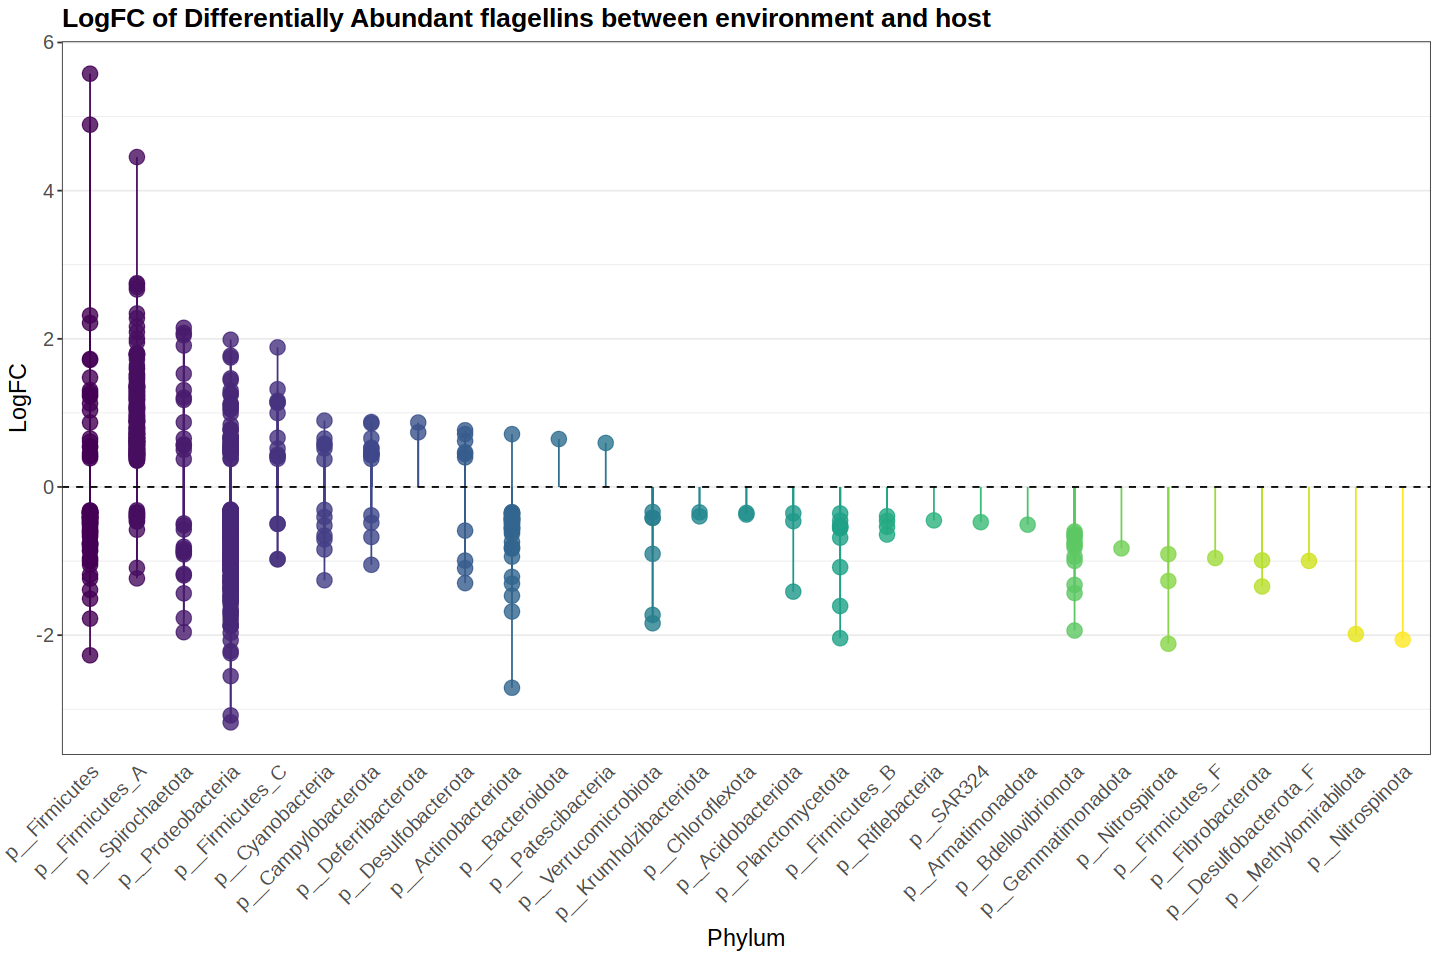

In [49]:
options(repr.plot.width=12,repr.plot.height=8)
ggplot(sigtabgen.nonrare.filt.biome1, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between environment and host")+
  labs(x = "Phylum", y = "LogFC")

In [50]:
mapBiomeToColor<-function(annotations){
    colorsVector = ifelse(annotations["category"]=="Plants", 
        "darkcyan", ifelse(annotations["category"]=="Animal", 
        "coral", "red"))
    return(colorsVector)
}

#### Create data.frame with metadata annotations

In [51]:
annotation.host <- data.frame(sample=DAs_fla_host@sam_data$Sample,
                        biome2=DAs_fla_host@sam_data$biome_2,
                        category=DAs_fla_host@sam_data$category)
rownames(annotation.host)=annotation.host$sample

sampleColors.host = mapBiomeToColor(annotation.host)

#### Create colors vector based on annotations

In [52]:
cols.vector.host =(t(sampleColors.host))
cols.vector.host = sampleColors.host[2:nrow(sampleColors.host),]

In [53]:
annotation.col = select(annotation.host,-sample)

In [54]:
annotation.row=data.frame(DAs_fla_host@tax_table)

#### Create abundance matrix for heatmap

In [55]:
matrix.host=as.matrix(DAs_fla_host@otu_table[,2:ncol(DAs_fla_host@otu_table)])
rownames(matrix.host)=rownames(DAs_fla_host@otu_table)

Mt2_GH<-log((matrix.host*1000)+1)

In [56]:
library(pheatmap)
library(viridis)
library(gridExtra)
library(ggplot2)

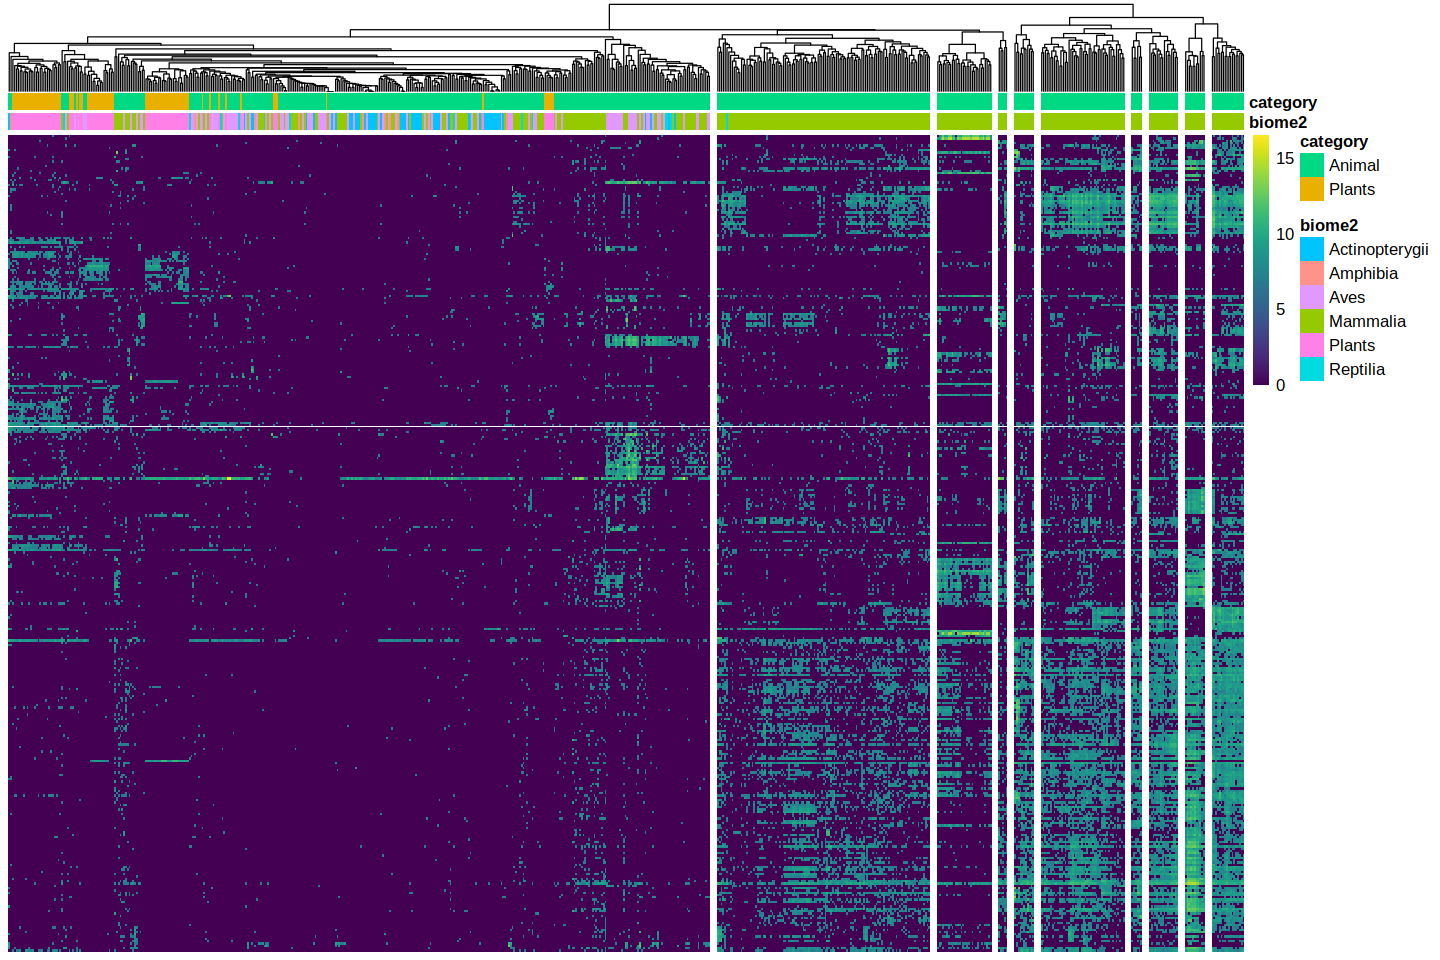

In [57]:
options(repr.plot.width=15,repr.plot.width=12)
pheatmap(Mt2_GH, cutree_cols = 10,
         cluster_cols=TRUE,
         cluster_rows=FALSE,
         show_rownames=F,
         show_colnames=F,
         labels_row=annotation.row$Phylum,
         annotation_col=annotation.col,
          color = viridis(n = 256, alpha = 1, 
                                   begin = 0, end = 1, option = "viridis")
)

## 3. Animals/Environmental

In [58]:
ps.animals.env=subset_samples(nonrare.psAll.filt,category!="Plants")
ps.animals.env

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1454 taxa and 692 samples ]
sample_data() Sample Data:       [ 692 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1454 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1454 tips and 1453 internal nodes ]

In [59]:
varianceThreshold = 1e-5
keepOTUs.anim.env = names(which(apply(otu_table(ps.animals.env), 1, var) > varianceThreshold))
filter_taxa_anim.env.nonrare.filt = prune_taxa(keepOTUs.anim.env, ps.animals.env)

dge.nonrare.filt.anim.env = phyloseq_to_edgeR(filter_taxa_anim.env.nonrare.filt, group="category")
# Perform binary test
et.nonrare.filt.anim.env = exactTest(dge.nonrare.filt.anim.env)
# Extract values from test results
tt.nonrare.filt.anim.env = topTags(et.nonrare.filt.anim.env, n=nrow(dge.nonrare.filt.anim.env$table), adjust.method="BH", sort.by="PValue")
res.nonrare.filt.anim.env = tt.nonrare.filt.anim.env@.Data[[1]]
alpha = 0.001
sigtab.nonrare.filt.anim.env = res.nonrare.filt.anim.env[(res.nonrare.filt.anim.env$FDR < alpha), ]
#sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(rarefied.psAll.filt)[rownames(sigtab), ], "matrix"))
#dim(sigtab)

sigtab.nonrare.filt.anim.env=filter(res.nonrare.filt.anim.env,FDR<0.01)
head(tt.nonrare.filt.anim.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.232739,11.23077,3.571169e-170,5.192480e-167
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.681773,11.22161,2.217910e-140,1.612420e-137
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,2.805084,11.85580,1.167445e-135,5.658215e-133
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.110978,14.10823,7.244926e-106,2.633531e-103
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.550352,10.96537,1.394940e-103,4.056485e-101
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.344626,11.36667,7.013927e-99,1.699708e-96


In [60]:
nrow(filter(sigtab.nonrare.filt.anim.env,logFC<1))

[1] 721

In [61]:
head(sigtab.nonrare.filt.anim.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.232739,11.23077,3.571169e-170,5.192480e-167
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.681773,11.22161,2.217910e-140,1.612420e-137
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,2.805084,11.85580,1.167445e-135,5.658215e-133
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.110978,14.10823,7.244926e-106,2.633531e-103
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.550352,10.96537,1.394940e-103,4.056485e-101
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.344626,11.36667,7.013927e-99,1.699708e-96


#### Export list of Differentially Abundant flagellins

In [62]:
DA.animals.env = rownames_to_column(sigtab.nonrare.filt.anim.env,var = "Accession")
#write_tsv(DA.animals.env,"edgeR/DA.animals.env.nonrare.filt.tsv")

In [63]:
theme_set(theme_bw())
sigtabgen.nonrare.filt.anim.env = subset(sigtab.nonrare.filt.anim.env, !is.na(Genus))

# Phylum order
x = tapply(sigtabgen.nonrare.filt.anim.env$logFC, sigtabgen.nonrare.filt.anim.env$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtabgen.nonrare.filt.anim.env$Phylum = factor(as.character(sigtabgen.nonrare.filt.anim.env$Phylum), levels = names(x))

# Genus order
x = tapply(sigtabgen.nonrare.filt.anim.env$logFC, sigtabgen.nonrare.filt.anim.env$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen.nonrare.filt.anim.env$Genus = factor(as.character(sigtabgen.nonrare.filt.anim.env$Genus), levels = names(x))

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


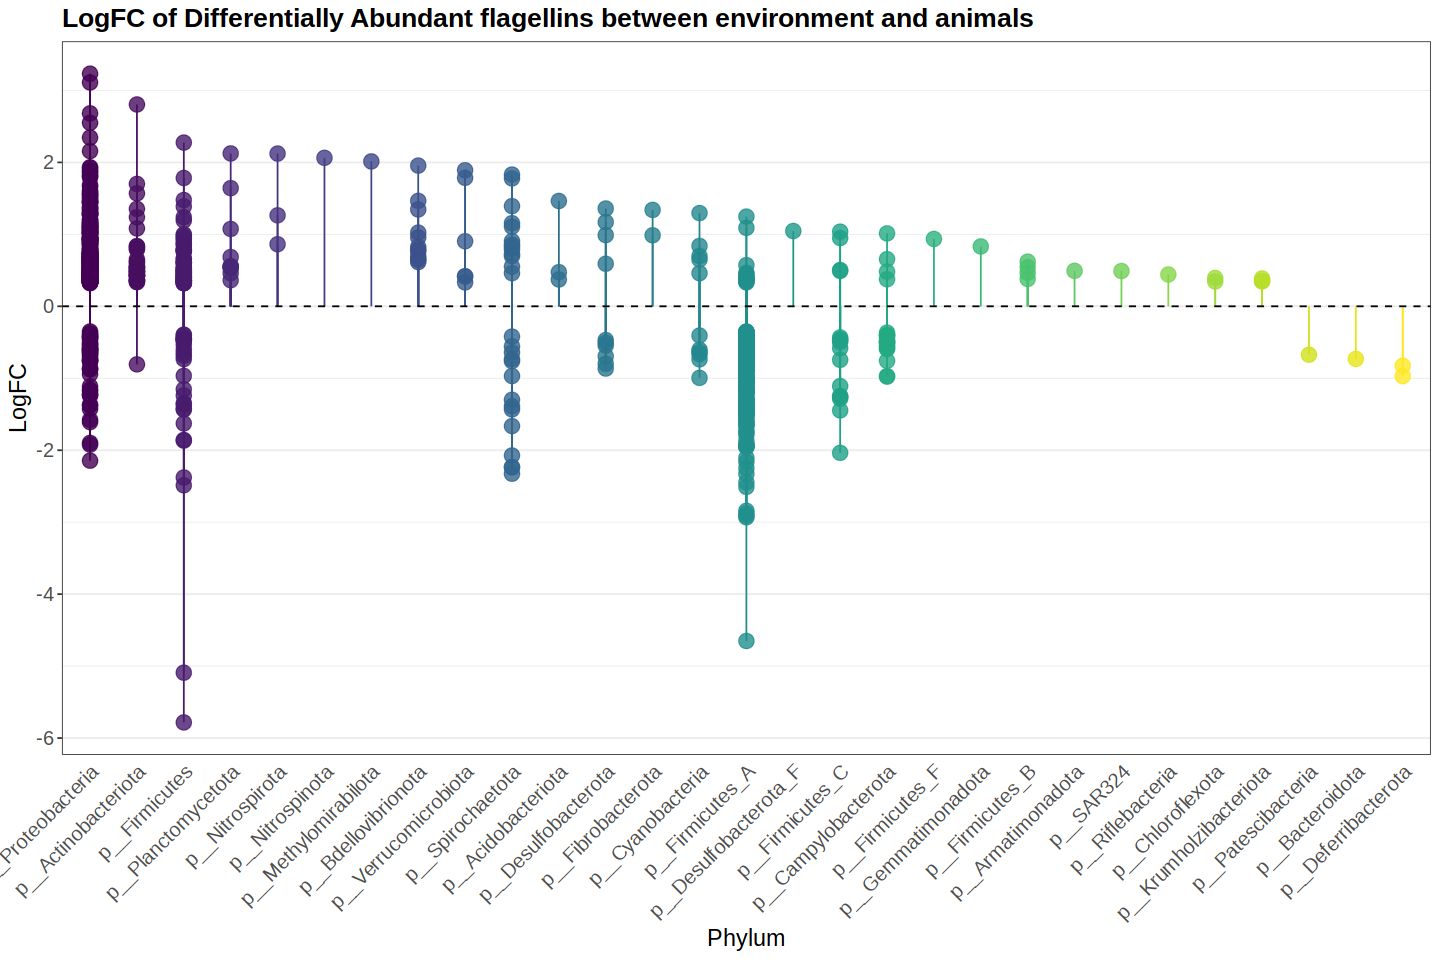

In [71]:
options(repr.plot.width=12,repr.plot.height=8)
ggplot(sigtabgen.nonrare.filt.anim.env, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between environment and animals")+
  labs(x = "Phylum", y = "LogFC")

In [72]:
head(sigtabgen.nonrare.filt.anim.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.232739,11.23077,3.571169e-170,5.192480e-167
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.681773,11.22161,2.217910e-140,1.612420e-137
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,2.805084,11.85580,1.167445e-135,5.658215e-133
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.110978,14.10823,7.244926e-106,2.633531e-103
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.550352,10.96537,1.394940e-103,4.056485e-101
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.344626,11.36667,7.013927e-99,1.699708e-96


In [67]:
lachnos.env.animals =filter(sigtabgen.nonrare.filt.anim.env,Family%in%"f__Lachnospiraceae")

In [68]:
nrow(lachnos.env.animals)

[1] 166

Warning message:
“Duplicated aesthetics after name standardisation: xend”


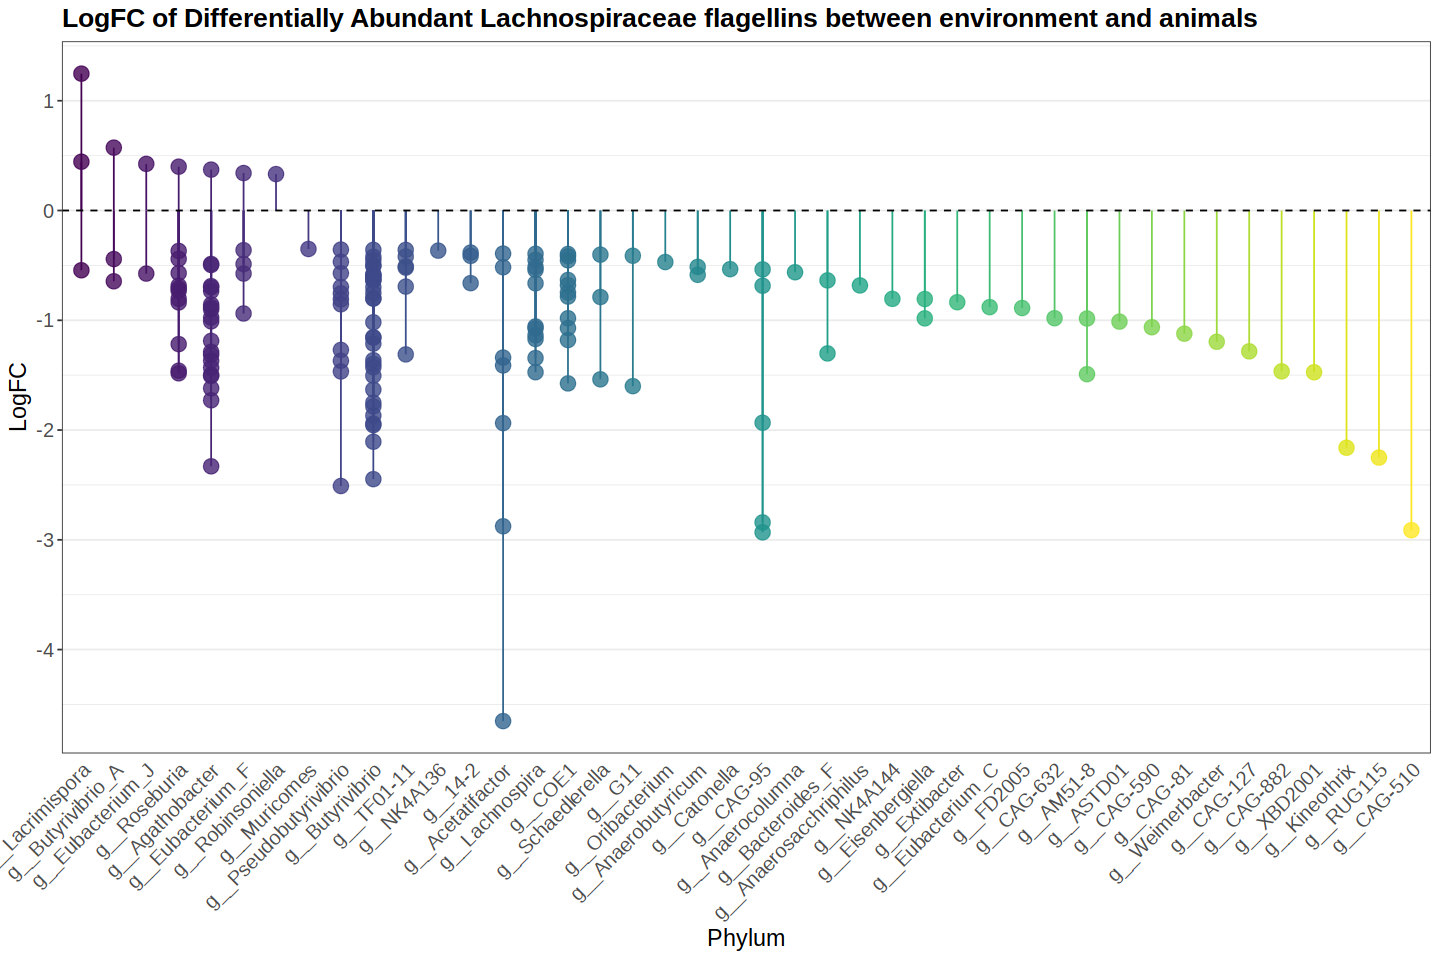

In [73]:
ggplot(lachnos.env.animals, aes(x = Genus, y = logFC, color = Genus)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Genus,xend=Genus),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant Lachnospiraceae flagellins between environment and animals")+
  labs(x = "Phylum", y = "LogFC")

## 4. Plants/Environmental

In [74]:
ps.plants.env=subset_samples(nonrare.psAll.filt,category!="Animal")
ps.plants.env

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1454 taxa and 220 samples ]
sample_data() Sample Data:       [ 220 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1454 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1454 tips and 1453 internal nodes ]

In [75]:
varianceThreshold = 1e-5
keepOTUs.plants.env = names(which(apply(otu_table(ps.plants.env), 1, var) > varianceThreshold))
filter_taxa_plant.env.nonrare.filt = prune_taxa(keepOTUs.plants.env, ps.plants.env)

dge.nonrare.filt.plant.env = phyloseq_to_edgeR(filter_taxa_plant.env.nonrare.filt, group="category")
# Perform binary test
et.nonrare.filt.plant.env = exactTest(dge.nonrare.filt.plant.env)
# Extract values from test results
tt.nonrare.filt.plant.env = topTags(et.nonrare.filt.plant.env, n=nrow(dge.nonrare.filt.plant.env$table), adjust.method="BH", sort.by="PValue")
res.nonrare.filt.plant.env = tt.nonrare.filt.plant.env@.Data[[1]]
alpha = 0.001
sigtab.nonrare.filt.plant.env = res.nonrare.filt.plant.env[(res.nonrare.filt.plant.env$FDR < alpha), ]
#sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(rarefied.psAll.filt)[rownames(sigtab), ], "matrix"))
#dim(sigtab)

sigtab.nonrare.filt.plant.env=filter(res.nonrare.filt.plant.env,FDR<0.01)

In [76]:
head(tt.nonrare.filt.plant.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SFH83235.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio sp900113655,2.915643,11.50974,1.655864e-40,2.351327e-37
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,-2.862100,15.32115,4.219625e-37,2.995934e-34
EEO87047.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Yersinia,s__Yersinia pestis,-2.170430,11.87717,3.493735e-27,1.653701e-24
EHS53753.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.283410,11.50523,1.832258e-26,6.504516e-24
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,-2.793694,12.18788,6.611969e-23,1.877799e-20
WP_043131923.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Aeromonadaceae,g__Aeromonas,s__Aeromonas caviae,-2.003482,11.82907,1.320598e-22,3.125416e-20


In [77]:
nrow(sigtab.nonrare.filt.plant.env)

[1] 277

#### Export list of Differentially Abundant flagellins

In [79]:
DA.plants.env = rownames_to_column(sigtab.nonrare.filt.plant.env,var = "Accession")
#write_tsv(DA.plants.env,"edgeR/DA.plants.env.nonrare.filt.tsv")

#### Plots

In [80]:
theme_set(theme_bw())
sigtabgen.nonrare.filt.plant.env = subset(sigtab.nonrare.filt.plant.env, !is.na(Genus))

# Phylum order
x = tapply(sigtabgen.nonrare.filt.plant.env$logFC, sigtabgen.nonrare.filt.plant.env$Phylum, function(x) max(x))
x = sort(x, TRUE)
           
sigtabgen.nonrare.filt.plant.env$Phylum = factor(as.character(sigtabgen.nonrare.filt.plant.env$Phylum), levels = names(x))

# Genus order
x = tapply(sigtabgen.nonrare.filt.plant.env$logFC, sigtabgen.nonrare.filt.plant.env$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen.nonrare.filt.plant.env$Genus = factor(as.character(sigtabgen.nonrare.filt.plant.env$Genus), levels = names(x))

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


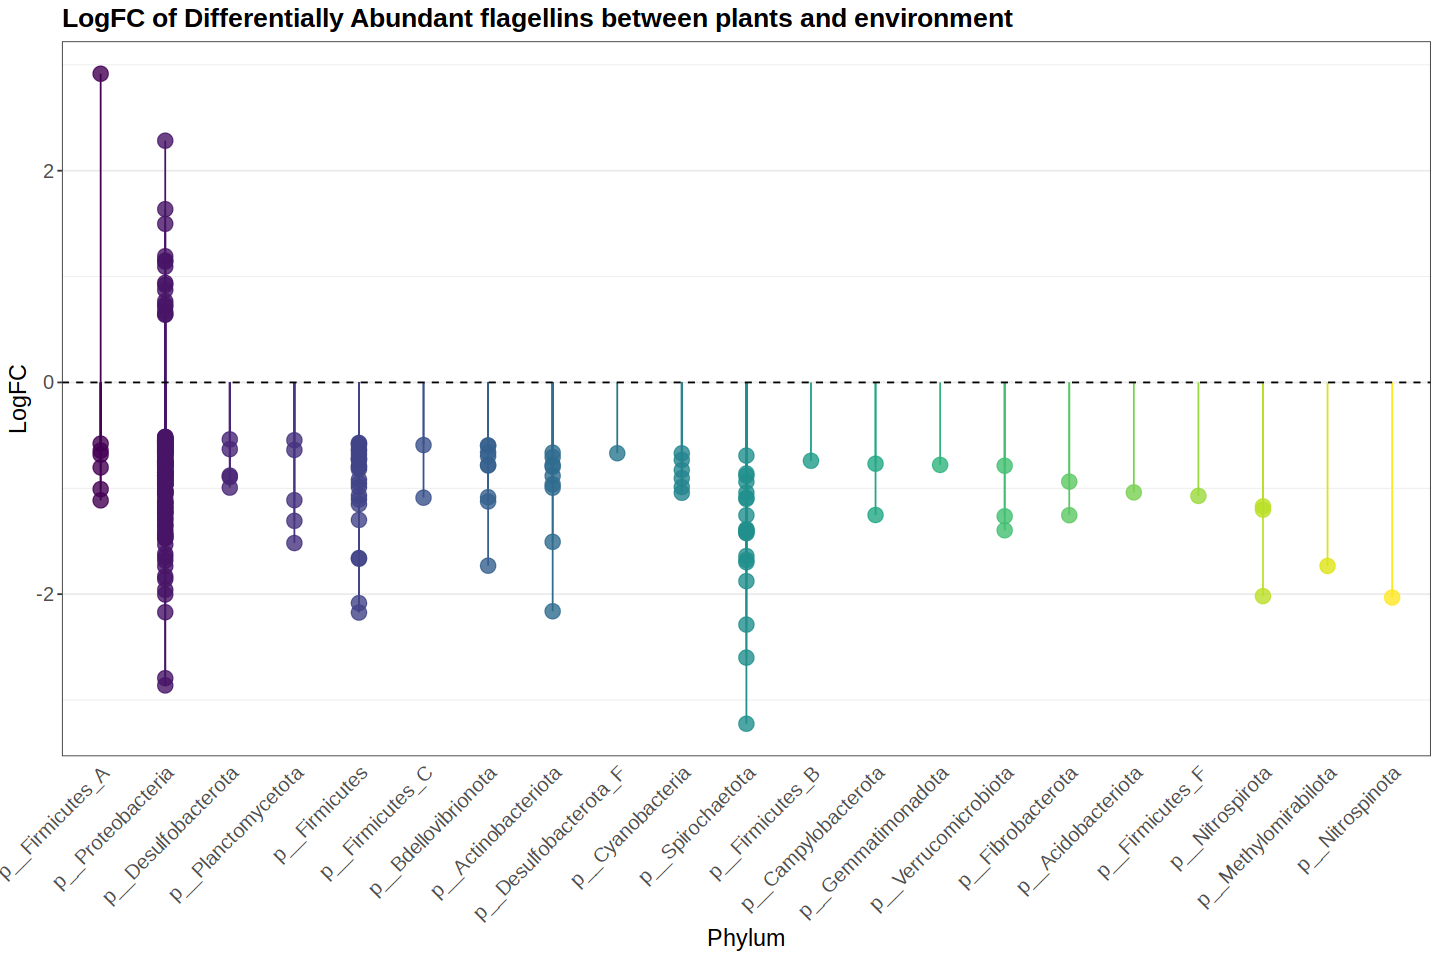

In [81]:
ggplot(sigtabgen.nonrare.filt.plant.env, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and environment")+
  labs(x = "Phylum", y = "LogFC")

In [82]:
#saveRDS(nonrare.psAll.filt, file = "nonrare.psAll.filt.rds")

## All pairwise comparisons

In [90]:
env_vs_animals = rownames_to_column(res.nonrare.filt.anim.env,var="Accession")%>% select(Accession,logFC,FDR)%>%
mutate(comparison=rep("env_vs_animals",n()))
host_env = rownames_to_column(sigtabgen.nonrare.filt.biome1,var="Accession")%>% select(Accession,logFC,FDR)%>%
mutate(comparison=rep("host_env",n()))
plant_env = rownames_to_column(sigtabgen.nonrare.filt.plant.env,var="Accession")%>% select(Accession,logFC,FDR)%>%
mutate(comparison=rep("plant_env",n()))
plant_vs_animals = rownames_to_column(sigtabgen.host.filt.nonrare,var="Accession")%>% select(Accession,logFC,FDR)%>%
mutate(comparison=rep("plant_vs_animals",n()))

In [91]:
all_comparisons <- bind_rows(env_vs_animals, host_env, plant_env, plant_vs_animals)

In [94]:
nrow(all_comparisons)

[1] 2901

In [95]:
#Create individual subsets of phyloseq objects for each category
ps.animals=subset_samples(nonrare.psAll.filt,category=="Animal")
ps.plants=subset_samples(nonrare.psAll.filt,category=="Plants")
ps.env=subset_samples(nonrare.psAll.filt,category="Environmental")

In [96]:
ps.animals

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1454 taxa and 559 samples ]
sample_data() Sample Data:       [ 559 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1454 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1454 tips and 1453 internal nodes ]

In [97]:
# Extract abundance matrix from the phyloseq object
OTU1 = as(otu_table(ps.animals), "matrix")
# transpose if necessary
if(taxa_are_rows(ps.animals)){OTU1 <- t(OTU1)}
# Coerce to data.frame
OTUdf = as.data.frame(OTU1)

In [98]:
head(OTU1)

,WP_018305791.1,KJS48310.1,OBW58796.1,ESU34160.1,KMY55506.1,WP_087615600.1,WP_039042127.1,PTY75990.1,PGK31169.1,WP_062514727.1,⋯,EMT52255.1,KQL46527.1,AKP76066.1,RDW20767.1,PLR90813.1,WP_055738703.1,WP_068777453.1,EPR26812.1,PIC98532.1,PID08009.1
ERS1065340,0,0,2,1,0,0,0,1,0,0,⋯,0,1,0,0,0,5,1,0,0,0
ERS1065341,1,0,1,0,0,0,0,3,0,0,⋯,4,5,0,0,5,25,4,0,0,0
ERS1065342,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,5,1,2,0,0
ERS1353918,3,0,1,1,0,0,0,1,0,0,⋯,1,1,0,0,1,73,8,1,0,0
ERS1353919,2,0,1,5,0,0,0,2,0,0,⋯,0,1,0,0,0,68,14,0,0,0
ERS1353920,3,0,1,1,2,0,0,0,0,0,⋯,1,1,0,1,0,68,23,1,0,0


In [99]:
createCountsMatrix = function(ps_object){
    OTU1 = as(otu_table(ps_object),"matrix")
    #if(taxa_are_rows(ps_object)){OTU1 <- t(OTU1)}
    OTUdf = as.data.frame(OTU1)
    OTUdf = rownames_to_column(OTUdf,var="Accession")
    
    #Read metadata table from phyloseq object
    metadata = as_tibble(ps_object@sam_data)
    category.value = metadata$category[1]
    
    #Read taxonomy table from phyloseq object
    #Finish this section: Create the vector with corresponding taxonomy for each accession, to further add to the output.table
    #taxonomy = as_tibble(ps_object@tax_table) %>%
     #          rownames_to_column(var = "Accession")
#    species = select(taxonomy,Species)
    
    #Create table and assign category
    output.table = mutate(OTUdf,totalCount= rowSums(across(where(is.numeric))))%>%
                mutate(category = category.value) %>%
                mutate(NoSamples = nrow(metadata)) %>%
                mutate(ProportionInCategory = totalCount/NoSamples) %>%
                mutate(PresentInCategory = ifelse(ProportionInCategory>0,TRUE,FALSE))%>%
                select(Accession,category,totalCount,NoSamples,ProportionInCategory,PresentInCategory)%>%
                rename_with(~paste0("ProportionIn_",category.value),ProportionInCategory)%>%
                rename_with(~paste0("PresentIn_",category.value),PresentInCategory)%>%
                rename_with(~paste0("totalCount_",category.value),totalCount)

    #mutate(category.table,ExtractCategorypresent = ifelse(rowSums(select(.,-c(Sample,category)))>0,TRUE,FALSE))
    
    return(output.table)
}

In [100]:
ps_subsets_list = list(ps.animals,ps.env,ps.plants)

In [102]:
counts.matrix = bind_rows(lapply(ps_subsets_list,createCountsMatrix))

In [103]:
counts.matrix %>%
        group_by(Accession)

Accession,category,totalCount_Animal,NoSamples,ProportionIn_Animal,PresentIn_Animal,totalCount_Environmental,ProportionIn_Environmental,PresentIn_Environmental,totalCount_Plants,ProportionIn_Plants,PresentIn_Plants
<chr>,<chr>,<dbl>,<int>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>
WP_018305791.1,Animal,182,559,0.32558140,TRUE,NA,NA,NA,NA,NA,NA
KJS48310.1,Animal,9,559,0.01610018,TRUE,NA,NA,NA,NA,NA,NA
OBW58796.1,Animal,66,559,0.11806798,TRUE,NA,NA,NA,NA,NA,NA
ESU34160.1,Animal,30,559,0.05366726,TRUE,NA,NA,NA,NA,NA,NA
KMY55506.1,Animal,93,559,0.16636852,TRUE,NA,NA,NA,NA,NA,NA
WP_087615600.1,Animal,53,559,0.09481216,TRUE,NA,NA,NA,NA,NA,NA
WP_039042127.1,Animal,54,559,0.09660107,TRUE,NA,NA,NA,NA,NA,NA
PTY75990.1,Animal,41,559,0.07334526,TRUE,NA,NA,NA,NA,NA,NA
PGK31169.1,Animal,38,559,0.06797853,TRUE,NA,NA,NA,NA,NA,NA


In [104]:
counts.animals = createCountsMatrix(ps.animals)  
counts.env = createCountsMatrix(ps.env)
counts.plants = createCountsMatrix(ps.plants)

In [105]:
createPresenceAbsenceMatrix = function(matrix1,matrix2,matrix3){
        tmp = rbind(matrix1,matrix2,matrix3)%>%
        group_by(Accession)


}

In [106]:
head(counts.animals)

,Accession,category,totalCount_Animal,NoSamples,ProportionIn_Animal,PresentIn_Animal
,<chr>,<chr>,<dbl>,<int>,<dbl>,<lgl>
1,WP_018305791.1,Animal,182,559,0.32558140,TRUE
2,KJS48310.1,Animal,9,559,0.01610018,TRUE
3,OBW58796.1,Animal,66,559,0.11806798,TRUE
4,ESU34160.1,Animal,30,559,0.05366726,TRUE
5,KMY55506.1,Animal,93,559,0.16636852,TRUE
6,WP_087615600.1,Animal,53,559,0.09481216,TRUE


In [107]:
test = full_join(counts.animals,counts.env,by="Accession") %>%
       full_join(counts.plants)

Joining, by = "Accession"


In [108]:
head(test)

,Accession,category.x,totalCount_Animal,NoSamples.x,ProportionIn_Animal,PresentIn_Animal,category.y,totalCount_Environmental,NoSamples.y,ProportionIn_Environmental,PresentIn_Environmental,category,totalCount_Plants,NoSamples,ProportionIn_Plants,PresentIn_Plants
,<chr>,<chr>,<dbl>,<int>,<dbl>,<lgl>,<chr>,<dbl>,<int>,<dbl>,<lgl>,<chr>,<dbl>,<int>,<dbl>,<lgl>
1,WP_018305791.1,Animal,182,559,0.32558140,TRUE,Environmental,359,779,0.46084724,TRUE,Plants,15,87,0.17241379,TRUE
2,KJS48310.1,Animal,9,559,0.01610018,TRUE,Environmental,93,779,0.11938383,TRUE,Plants,4,87,0.04597701,TRUE
3,OBW58796.1,Animal,66,559,0.11806798,TRUE,Environmental,87,779,0.11168164,TRUE,Plants,4,87,0.04597701,TRUE
4,ESU34160.1,Animal,30,559,0.05366726,TRUE,Environmental,74,779,0.09499358,TRUE,Plants,5,87,0.05747126,TRUE
5,KMY55506.1,Animal,93,559,0.16636852,TRUE,Environmental,126,779,0.16174583,TRUE,Plants,6,87,0.06896552,TRUE
6,WP_087615600.1,Animal,53,559,0.09481216,TRUE,Environmental,93,779,0.11938383,TRUE,Plants,2,87,0.02298851,TRUE


In [109]:
head(ps.animals@otu_table)

,ERS1065340,ERS1065341,ERS1065342,ERS1353918,ERS1353919,ERS1353920,ERS1353921,ERS1353922,ERS1353923,ERS1353924,⋯,36UNCULTURED_S10,400UNCULTURED_S11,40UNCULTURED_S15,4UNCULTURED_S2,500UNCULTURED_S13,8UNCULTURED_S5,lucaAR31_S16,lucaAR32_S17,lucaAR33_S18,lucaAR34_S19
WP_018305791.1,0,1,0,3,2,3,3,1,1,0,⋯,1,0,0,3,0,0,3,0,0,8
KJS48310.1,0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,1,0
OBW58796.1,2,1,0,1,1,1,1,4,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ESU34160.1,1,0,0,1,5,1,2,2,1,0,⋯,0,0,0,0,0,0,0,0,0,0
KMY55506.1,0,0,0,0,0,2,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WP_087615600.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
